# Import data

In [1]:
!pip install emoji
!pip install transformers torch

In [2]:
import torch
import emoji
import numpy as np
import pandas as pd
import os
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from scipy.special import softmax
from wordcloud import WordCloud
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/070macbookair/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/070macbookair/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/070macbookair/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#Import data
df = pd.read_json("/Users/070macbookair/Desktop/waitrose.json")
df.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,matching_rules,display_text_range,retweeted_status,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_entities,scopes
0,2020-07-29 10:28:58,1288421250000000000,1288421250000000000,RT @HelpThemHelpUs_: Our friends at @Potsandco...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,NaN,NaN,NaN,...,[{'tag': None}],None,{'created_at': 'Tue Jul 28 16:29:56 +0000 2020...,NaN,NaN,NaN,None,None,None,NaN
1,2020-11-17 16:31:19,1328737494000000000,1328737494000000000,@HOOODINIIII @roh17h @Samuel51 @sainsburys @Ma...,"<a href=""http://twitter.com/download/iphone"" r...",False,1.328654e+18,1.328654e+18,1.327758e+18,1.327758e+18,...,[{'tag': None}],"[57, 133]",None,NaN,NaN,NaN,None,None,None,NaN
2,2020-02-28 20:19:01,1233486785000000000,1233486785000000000,@waitrose the wine you delivered yesterday was...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,NaN,4.632874e+07,4.632874e+07,...,[{'tag': None}],None,None,NaN,NaN,NaN,None,None,None,NaN
3,2020-11-13 09:21:04,1327179666000000256,1327179666000000256,RT @jlandpartners: This Christmas we want to #...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,NaN,NaN,NaN,...,[{'tag': None}],None,{'created_at': 'Fri Nov 13 07:00:00 +0000 2020...,NaN,NaN,NaN,None,None,None,NaN
4,2020-06-04 20:54:01,1268647218000000000,1268647218000000000,RT @RebeccaTillett1: @waitrose if the U.K. ach...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,[{'tag': None}],None,{'created_at': 'Thu Jun 04 16:31:25 +0000 2020...,NaN,NaN,NaN,None,None,None,NaN


# Text Processing

## Generate ‘full_text’ column

In [4]:
#Change the index of the extended_tweet from str to int
def convert_index_to_int(dictionary):
    if dictionary is not None and isinstance(dictionary, dict):
        return {int(key): value for key, value in dictionary.items()}
    else:
        return dictionary 

df['extended_tweet'] = df['extended_tweet'].apply(lambda x: convert_index_to_int(x))

In [5]:
#Create a new column full_text, and fill the corresponding value in extended_tweet into full_text.
df['full_text'] = [x['full_text'] if isinstance(x, dict) and 'full_text' in x else None for x in df['extended_tweet']]

In [6]:
df['full_text'].head()

0    None
1    None
2    None
3    None
4    None
Name: full_text, dtype: object

In [7]:
# Fill in the full_text where full_text is None with the corresponding value of text
df['full_text'] = [y if x==None else x for x,y in zip(df['full_text'],df['text'])]

In [8]:
df['full_text'].head(20)

0     RT @HelpThemHelpUs_: Our friends at @Potsandco...
1     @HOOODINIIII @roh17h @Samuel51 @sainsburys @Ma...
2     @waitrose the wine you delivered yesterday was...
3     RT @jlandpartners: This Christmas we want to #...
4     RT @RebeccaTillett1: @waitrose if the U.K. ach...
5     @Peterkay2k11 @Morrisons @Tesco @sainsburys @a...
6     @DrJDrooghaag @GeekOnTheLoose @digitalcloudgal...
7     @NLeespeaking @laworfiction @waitrose @Francis...
8     @serichards @waitrose @InstaVoltUK @engenieUK ...
9     @mcgjingsorbust @waitrose We used to enjoy the...
10    I signed the open letter asking @Tesco @asda @...
11    @sonicfairy @lizbilney @LeaveEUOfficial @LidlG...
12    @DeliaTurnbull @asda @Morrisons @LidlGB @coopu...
13    @waitrose could you please tell me what feed i...
14    I signed the open letter asking @Tesco @asda @...
15    RT @waitrose: @MarcusRashford @jlandpartners @...
16    RT @NeilTho68822310: @RebeccaTillett1 @spacean...
17    @Geoff_Walton @wenhiggins @DeborahMeaden @

## Remove Noise

In [9]:

# Removing mentions
def remove_mentions(dataset):
    return re.sub(r'@\w+'," ",dataset)
df['full_text']= df['full_text'].apply(lambda x: remove_mentions(x))

# Remove URLs
def remove_URLs(dataset):
    return re.sub(r'https?://\S+|www\.\S+',' ',dataset)
df['full_text']= df['full_text'].apply(lambda x: remove_URLs(x))

# Remove emails
def remove_emails(dataset):
    return re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',' ',dataset)
df['full_text']= df['full_text'].apply(lambda x: remove_emails(x))

# Transfer emoji to text
df['full_text'] = df['full_text'].apply(lambda x: emoji.demojize(x))

# Remove punctuations
def remove_punctuations(dataset):
    return re.sub(r'[^\w\s]'," ", dataset)
df['full_text']= df['full_text'].apply(lambda x: remove_punctuations(x))

# Remove numbers
def remove_numbers(dataset):
    return re.sub('[0-9]+', '', dataset)
df['full_text']= df['full_text'].apply(lambda x: remove_numbers(x))


# Cleaning and removing the stop words list from the tweet text
stop_words = stopwords.words('english')
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
df['full_text'] = df['full_text'].apply(lambda x: cleaning_stopwords(x))


#Lower case 
df['full_text'] = df['full_text'].str.lower()


df['full_text'].head(100)



0     rt our friends puddings donating profits sales...
1                            i go i definitely shopping
2          wine delivered yesterday made violently sick
3     rt this christmas want givealittlelove because...
4     rt u k achieves trade deal us waitrose commit ...
                            ...                        
95                                   it really good fun
96                      i bear mind lol sit tweet jokes
97      i normally shopper yeast i went i surprised see
98    hi would appreciate response get missing froze...
99    rt stopped going stand free amp murdoch papers...
Name: full_text, Length: 100, dtype: object

In [10]:
df['full_text'].head(20)

0     rt our friends puddings donating profits sales...
1                            i go i definitely shopping
2          wine delivered yesterday made violently sick
3     rt this christmas want givealittlelove because...
4     rt u k achieves trade deal us waitrose commit ...
5                                    for support advice
6                                                      
7              how know man exempt with visual clue ask
8                       let environment saving together
9     we used enjoy waitrose leckford free range chi...
10                 i signed open letter asking join amp
11                                        confused_face
12    retweeting this ok_hand_light_skin_tone ok_han...
13    could please tell feed used meat products come...
14                 i signed open letter asking join amp
15              rt your efforts little lot so behalf th
16    rt us apparently insisted drop country origin ...
17                          another good reason 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24802 entries, 0 to 24801
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   created_at                 24802 non-null  datetime64[ns]
 1   id                         24802 non-null  int64         
 2   id_str                     24802 non-null  int64         
 3   text                       24802 non-null  object        
 4   source                     24802 non-null  object        
 5   truncated                  24802 non-null  bool          
 6   in_reply_to_status_id      9288 non-null   float64       
 7   in_reply_to_status_id_str  9288 non-null   float64       
 8   in_reply_to_user_id        11291 non-null  float64       
 9   in_reply_to_user_id_str    11291 non-null  float64       
 10  in_reply_to_screen_name    11048 non-null  object        
 11  user                       24802 non-null  object        
 12  geo      

In [12]:
monthly_counts = df.groupby(df['created_at'].dt.to_period('M')).size()
monthly_counts

created_at
2020-01     741
2020-02     833
2020-03    4892
2020-04    2948
2020-05    1023
2020-06    2093
2020-07    2572
2020-08     874
2020-09    1239
2020-10    1563
2020-11    3321
2020-12    2703
Freq: M, dtype: int64

In [13]:
df2 = df[df['created_at'].dt.month == 12]

In [14]:
df2['full_text'].head()

24    come on isn time supermarkets committed exclus...
42    waitrose basically funnel everybody wee tight ...
53    rt when really need kind word gesture we abili...
60                                rt loudly_crying_face
63    thanks local waitrose closed delivery option l...
Name: full_text, dtype: object

In [15]:
df2.shape

(2703, 38)

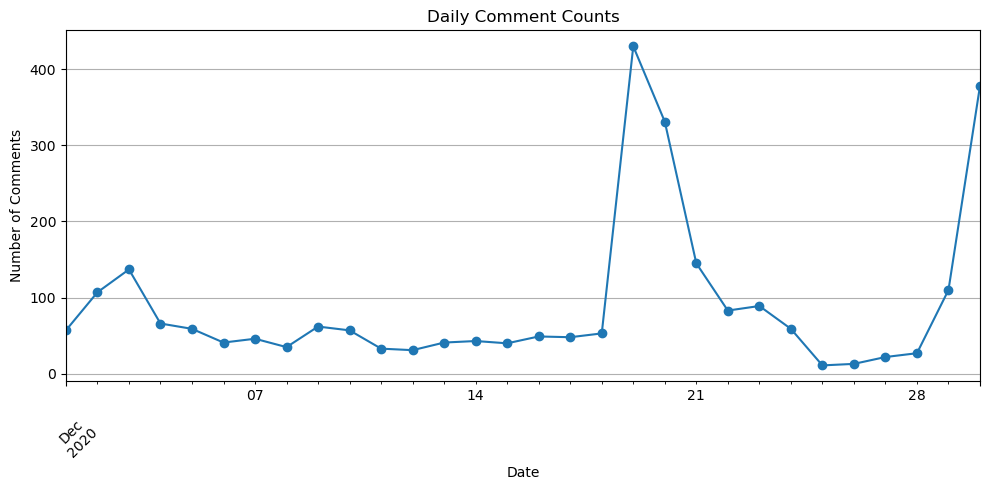

In [16]:
# Calculate the number of comments per day
daily_counts = df2.resample('D', on='created_at').size()

# Plotting line graphs
daily_counts.plot(
    figsize=(10, 5), 
    marker='o', 
    linestyle='-', 
    title='Daily Comment Counts'
)

plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()


In [17]:
# Lemmatization
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
df2['full_text'] = df2['full_text'].apply(lambda x: lemmatizer_on_text(x))

     

/var/folders/hl/zvxnpgb53j78sh4663wdwq3h0000gn/T/ipykernel_95968/3807534139.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['full_text'] = df2['full_text'].apply(lambda x: lemmatizer_on_text(x))


# Sentiment Analysis


In [18]:
# Use pretrained model
# Load pre-trained model and tokenizer
model_name = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

def sentiment_score(review_text):
    # Encode the text
    encoded_review = tokenizer.encode_plus(
        review_text,
        max_length=512,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    # Forward pass, get logits
    input_ids = encoded_review['input_ids'].to('cpu')
    attention_mask = encoded_review['attention_mask'].to('cpu')

    with torch.no_grad():
        output = model(input_ids, attention_mask)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)

    return scores


/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [19]:
# Example tweets
tweets = df2['full_text']
results = []


# Get sentiment scores for each tweet
for tweet in tweets:
    scores = sentiment_score(tweet)
    results.append({'Tweet': tweet, 'Scores': scores})

    
    print(f'Tweet: "{tweet}"')
    print(f'Scores: {scores}')


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Tweet: "come on isn time supermarkets committed exclusively peatfree compost offer"
Scores: [0.14023231 0.589189   0.27057868]


/opt/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Tweet: "waitrose basically funnel everybody wee tight channel get"
Scores: [0.15068077 0.81222266 0.03709657]
Tweet: "rt when really need kind word gesture we ability make change starts right heart_suit tha"
Scores: [0.02359029 0.57366186 0.4027478 ]
Tweet: "rt loudly_crying_face"
Scores: [0.5770113  0.37380818 0.04918052]
Tweet: "thanks local waitrose closed delivery option like food"
Scores: [0.09084511 0.802565   0.10658987]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "bn plus covid rates relief handed back b amp m joins list the johnlewis pa"
Scores: [0.01506653 0.8169378  0.16799577]
Tweet: "banquet"
Scores: [0.13769913 0.6741592  0.18814163]
Tweet: "it really good fun"
Scores: [0.00424925 0.0248323  0.9709184 ]
Tweet: "hi please stop lobbying delay cleanairzones childr

Tweet: "making sure online orders honoured priority stores getting blitzed wondering"
Scores: [0.11078636 0.775056   0.11415765]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "agree i actually looked"
Scores: [0.05192253 0.7207767  0.22730085]
Tweet: "i will look thanks"
Scores: [0.01423788 0.2914986  0.6942635 ]
Tweet: "have dm"
Scores: [0.11126719 0.726858   0.16187486]
Tweet: "yep realised popeye pointed mistake gherkins waitrose sparkling_heart"
Scores: [0.08829679 0.7667326  0.14497055]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt loudly_crying_face"
Scores: [0.5770113  0.37380818 0.04918052]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: ""
Scores: [0.2582943  0.45127246 0.29043326]
Tweet: "rt hi

Tweet: "rt à la suite de l enquête de l les supermarchés au royaume uni ont décidé de retirer les produits à ba"
Scores: [0.11734189 0.81824934 0.0644088 ]
Tweet: "un avis la dessus"
Scores: [0.20696802 0.62813115 0.16490085]
Tweet: "ah cool thanks much responding smiling_face_with_smiling_eyes"
Scores: [0.00149638 0.01670496 0.9817986 ]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "can actually believe easter chocolates shelves already poor epiphany even happened"
Scores: [0.37088254 0.41730288 0.21181461]
Tweet: "rt i knew come good visiting home thanks continued support million sel"
Scores: [0.00257529 0.0347692  0.9626555 ]
Tweet: "rt you re business rates relief do the decent thing follow"
Scores: [0.0943429  0.70765007 0.19800702]
Tweet: "rt across tier people looking despair huge turkeys hoping nigella tell us"
Scores: [0.2785683  0.6691922  0.05223947]
Tweet: "great see give back bus

Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "visited chester store armed husbands work shopping bonus voucher small list phone"
Scores: [0.01877912 0.79308236 0.18813857]
Tweet: "hi help"
Scores: [0.2241556  0.5832877  0.19255675]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt dear i want tab i shop online states add food bank i wa

Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "squinting_face_with_tongue"
Scores: [0.16138825 0.7573172  0.08129452]
Tweet: "wow fabulous we loving givealittlelove campaign amp"
Scores: [0.00143314 0.01015438 0.98841244]
Tweet: "rt hi at ocado run scheme called you give we give customers purc"
Scores: [0.02719026 0.8725109  0.10029878]
Tweet: "rt finally shop bought vegan quiche face_savoring_food joining two quiches new plant based range spinach roasted tomato"
Scores: [0.00543861 0.58625454 0.40830684]
Tweet: "yes something really warrants prime shelf real estate"
Scores: [0.03356953 0.48737064 0.47905982]
Tweet: "i swap turkey able see amp h

Tweet: "thanks lovely gifts families"
Scores: [0.00275965 0.0233119  0.9739284 ]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "i alone christmas provide cat pics demand consid"
Scores: [0.07876439 0.85653824 0.06469745]
Tweet: "rt hi amp we green_heart givealittlelove campaign could givealittleair resigning membership"
Scores: [0.01352861 0.5109554  0.47551596]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt have grabbed one dragon eggs yet these little fiery treats offer fire fire"
Scores: [0.02227209 0.46039605 0.5173319 ]
Tweet: "rt so told seek legal advice i asked print sprout photo without asking"
Scores: [0.25137392 0.720076   0.02855003]
Tweet: "rt i know walthamstow needs read travel pla

Tweet: "thank cancelling family christmas main last minute why let place order co"
Scores: [0.41626713 0.54628944 0.03744339]
Tweet: "rolling_on_the_floor_laughing rolling_on_the_floor_laughing"
Scores: [0.115881   0.5853877  0.29873133]
Tweet: "true"
Scores: [0.0926247  0.5022141  0.40516123]
Tweet: "how long take guys come back someone serious complaint been waiting wee"
Scores: [0.32668322 0.634652   0.03866481]
Tweet: "how giving black actors abuse help achieve thei"
Scores: [0.35360438 0.6129233  0.03347234]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "i agree entirely you wrong i ask everyday in"
Scores: [0.36054093 0.5587827  0.08067633]
Tweet: "rt à la suite de nos révélations les supermarchés britanniques suspendent les produits à base de cochon flexed_biceps"
Scores: [0.11918172 0

Tweet: "loading another delivery morning articulated_lorry christmas_tree cotswoldforage cf haulage waitrose christmas"
Scores: [0.02876346 0.9159209  0.05531564]
Tweet: "rt join demanding drops supplier today filmed"
Scores: [0.02758404 0.91730505 0.05511085]
Tweet: "rt a delivery driver told one customers given"
Scores: [0.19643427 0.76787585 0.03568991]
Tweet: "likewise"
Scores: [0.179935   0.64405733 0.1760077 ]
Tweet: "the families flouting rules filling mosques"
Scores: [0.65761393 0.33337772 0.0090084 ]
Tweet: "missing online christmas shop christmas turkey stuffing waitrosechristmasshopisajoke"
Scores: [0.13148227 0.77550024 0.09301739]
Tweet: "rt i know walthamstow needs read travel plans xmas mean stay home al"
Scores: [0.14470343 0.8038784  0.05141817]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt thanks mince pies share local elderly residents virtual chris"
Scores: [0.0090289

Tweet: "rt so told seek legal advice i asked print sprout photo without asking"
Scores: [0.25137392 0.720076   0.02855003]
Tweet: "i imagine hard isolate everyone ever"
Scores: [0.57502794 0.39712313 0.02784892]
Tweet: "rt loudly_crying_face"
Scores: [0.5770113  0.37380818 0.04918052]
Tweet: "rt best i ever heard someone ordered nappies got cat litter substitute"
Scores: [0.01892869 0.24874985 0.7323215 ]
Tweet: "you canadadada though so excused"
Scores: [0.02115343 0.51000947 0.4688371 ]
Tweet: "rt we running another christmas giveaway to make mincemeat recipe giving"
Scores: [0.01293646 0.67742807 0.3096355 ]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "i think gr"
Scores: [0.11277787 0.71538585 0.17183632]
Tweet: "i prefer"
Scores: [0.06465081 0.50333977 0.43200946]
Tweet

Tweet: "switching one type plastic another cannot solve"
Scores: [0.63344014 0.34431636 0.02224349]
Tweet: "i"
Scores: [0.26326513 0.49000207 0.24673277]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "disapppointed note i complete christmas order website last night"
Scores: [0.01659807 0.84752566 0.1358763 ]
Tweet: "well know you get joints iceland"
Scores: [0.25913426 0.66244817 0.07841755]
Tweet: "rt we running another christmas giveaway to make mincemeat recipe giving"
Scores: [0.01293646 0.67742807 0.3096355 ]
Tweet: "join demanding drops supplier today filmed"
Scores: [0.08020075 0.88849694 0.0313023 ]
Tweet: "roast potatoes butter frozen no information label thanks"
Scores: [0.05230822 0.8443342  0.10335758]
Tweet: "there need you know everyone situation but thanks pointless response"
Scores: [0.5212873  0.39838523 0.08032743]
Tweet: "rt à la suite de nos révélations les supermarchés br

Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "hi please stop lobbying delay cleanairzones children need clean air i call"
Scores: [0.4067438  0.51786155 0.07539462]
Tweet: "rt so told seek legal advice i asked print sprout photo without asking"
Scores: [0.25137392 0.720076   0.02855003]
Tweet: "service amp availability report spacious takes comfortable service victory"
Scores: [0.01258552 0.3656416  0.6217729 ]
Tweet: "and thank rustington donations"
Scores: [0.01157757 0.41197503 0.5764474 ]
Tweet: "rt just seen tweet"
Scores: [0.1373748  0.76854414 0.09408106]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt heart please drop"
Scores: [0.5152025  0.4166697  0.06812777]
Tweet: "ye

Tweet: "huge thank local residents amp businesses generously donated inc"
Scores: [0.00193635 0.04611527 0.95194834]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "this really disappointing please remedy immediately we expect b"
Scores: [0.90216887 0.08900756 0.00882355]
Tweet: "i proud young niece lucy bowler"
Scores: [0.00154953 0.03584851 0.96260196]
Tweet: "mrs b winning special birthday croissants instead merci beaucoup winning"
Scores: [0.03118727 0.4274603  0.54135245]
Tweet: "rt so told seek legal advice i asked print sprout photo without asking"
Scores: [0.25137392 0.720076   0.02855003]
Tweet: "givealittlelove"
Scores: [0.04741408 0.45

Tweet: "i invested i nee"
Scores: [0.44742656 0.50678664 0.04578677]
Tweet: "just discovered thoughts study weekend its enough"
Scores: [0.04391098 0.61507004 0.34101897]
Tweet: "excellent although vit one"
Scores: [0.01988492 0.14727269 0.83284235]
Tweet: "thank wonderful abingdon amp wantage amp trolley full love ki"
Scores: [0.00179968 0.0275631  0.9706372 ]
Tweet: "rt incredible charity show put together so proud work company capable"
Scores: [0.00269244 0.01601281 0.98129475]
Tweet: "you re business rates relief do the decent thing follow"
Scores: [0.08136876 0.655581   0.26305023]
Tweet: "come woman_facepalming_light_skin_tone"
Scores: [0.07464144 0.84926057 0.07609801]
Tweet: "hi last day order click collect pick local store"
Scores: [0.07873408 0.8646664  0.05659948]
Tweet: "i think idea good one though"
Scores: [0.0075096  0.12357304 0.86891735]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]

Tweet: "brilliant and true"
Scores: [0.0061436  0.17615199 0.81770444]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "the staff scoffing mince pies guise taste testing apawrently studies revealed finest w"
Scores: [0.23129232 0.68164444 0.08706329]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt let know need turkey want swap ok_hand"
Scores: [0.0655997  0.87065446 0.06374584]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "go local butcher they selling homewares clothing whilst competit"
Scores: [0.01994771 0.9070628  0.07298946]
Tweet: "please try enforce safe distancing stores better felt like one way ticket icu ne"
Scores: [0.11655352 0.67693466 0.2065118 ]
Tweet: "this acceptable a responsible company work organisat

Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "lovely gesture bouquet"
Scores: [0.00178769 0.02557427 0.972638  ]
Tweet: "rt loudly_crying_face"
Scores: [0.5770113  0.37380818 0.04918052]
Tweet: "rt loudly_crying_face"
Scores: [0.5770113  0.37380818 0.04918052]
Tweet: "i delivery due will possible request turkey falls within fairly tight"
Scores: [0.00754154 0.86848736 0.12397116]
Tweet: "some people might want reverse numbers"
Scores: [0.19929208 0.7687371  0.03197088]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt hi i local councillor aylesford kent along c"
Scores: [0.01377522 0.9116993  0.07452547]
Tweet: "care sparkles profit sparkles gonna keep things way x"
Scores: [0.00573146 0.19120269 0.80306584]
Tweet: "rt duck violates the rights of ducks causing them extreme pain and stress broken_heart this thefoultruth needs t"


Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "ooh"
Scores: [0.2766325  0.500681   0.22268654]
Tweet: "hi please stop lobbying delay cleanairzones children need clean air i call"
Scores: [0.4067438  0.51786155 0.07539462]
Tweet: "much point click collect christmas service day collection today"
Scores: [0.03054683 0.88203824 0.08741494]
Tweet: "that sad happy xmas"
Scores: [0.16340652 0.48085043 0.35574308]
Tweet: "dear amp i one k people think helping"
Scores: [0.2252648  0.72325194 0.05148334]
Tweet: "they garages london either"
Scores: [0.24143499 0.6999628  0.0586023 ]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "same shopping neighbour well large family amp sign queue"
Scores: 

Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "sainsbury say kept amount relating argos shops i think"
Scores: [0.11432572 0.84640926 0.03926509]
Tweet: "rt is turkey alive need company"
Scores: [0.04652504 0.79631436 0.15716065]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt should ordered definitely received turkey may got"
Scores: [0.01536693 0.57987607 0.40475696]
Tweet: "tres chère madame sans vouloir vous offenser vous êtes"
Scores: [0.13914117 0.77986133 0.08099748]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "thank action needed brands need update packaging consumers informe"
Scores: [0.10236327 0.8306649  0.06697183]
Tweet: "closing whole boxing day essential workers spend longer wit"
Scores: [0.04998894 0.88294965 0.067061

Tweet: "look forward seeing snaps"
Scores: [0.00310192 0.10452104 0.892377  ]
Tweet: "rt loved hearing special givealittlelove messages support amp"
Scores: [0.00199157 0.02356532 0.9744431 ]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "you really must"
Scores: [0.04966592 0.55786246 0.39247167]
Tweet: "pop store get replaced that tesco works anyway waitrose mil"
Scores: [0.05844377 0.75024503 0.19131124]
Tweet: "ummmm finding lp good moment ps i commission rolling_on_the_floor_laughing"
Scores: [0.00424257 0.08214463 0.9136128 ]
Tweet: "does every home delivery make much noise dustcart"
Scores: [0.42020822 0.55570483 0.02408695]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt star your man match matty brown ycfc red_circle blue_circle"
Scores: [0.01490684 0.84268475 0.14240842]
Tweet: "congratu

Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt join demanding drops supplier today filmed gover"
Scores: [0.06330168 0.8890051  0.04769312]
Tweet: "thanks m amp s seem wedding cakes anymore i checked i looking"
Scores: [0.09979831 0.8043954  0.09580632]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "friendly staff hex

Tweet: "um i think might thinking he extraordinari"
Scores: [0.08899837 0.8629155  0.0480862 ]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt have grabbed one dragon eggs yet these little fiery treats offer fire fire"
Scores: [0.02227209 0.46039605 0.5173319 ]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "say vegetarian sausage roll recipe delicious"
Scores: [0.00325555 0.06319971 0.93354475]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "wtf a wage paid extra"
Scores: [0.4702704  0.5033438  0.02638577]
Tweet: "i calling follow footsteps amp p"
Scores: [0.04621456 0.8770347  0.07675077]
Tweet: "rt loudly_crying_face"
Scores: [0.5770113  0.37380818 0.04918052]
Tweet: "used develop bit complex hot drinks machine shrewsb

Tweet: "rt hi i local councillor aylesford kent along c"
Scores: [0.01377522 0.9116993  0.07452547]
Tweet: "hi please stop lobbying delay cleanairzones children need clean air i call"
Scores: [0.4067438  0.51786155 0.07539462]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "i print digital version my waitrose card account"
Scores: [0.05407632 0.87151057 0.0744132 ]
Tweet: "rt this friday th december alongside presented hosting give a"
Scores: [0.00667124 0.9361424  0.05718642]
Tweet: "also i want food bank items added cost"
Scores: [0.5112448  0.45531    0.03344521]
Tweet: "rt still caring sharing refusing follow large retail groups returnin"
Scores: [0.00482851 0.41125417 0.5839173 ]
Tweet: "if proud stamping racism will look potential issues"
Scores: [0.596018   0.390865   0.01311697]
Tweet: "rt à la suite de nos révélations les supermarchés britanniques suspendent les produits à base de coc

Tweet: ""
Scores: [0.2582943  0.45127246 0.29043326]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt polar bears optical hairs c"
Scores: [0.07534566 0.8318468  0.09280752]
Tweet: "quorn saying helping hospitality industry even means buying mo"
Scores: [0.08020578 0.74504286 0.17475143]
Tweet: "delighted shrewsbury pretzels last week not"
Scores: [0.17056568 0.6447075  0.18472686]
Tweet: "rt at local morrisons food already bagged"
Scores: [0.27820235 0.68712306 0.03467461]
Tweet: "hope okay"
Scores: [0.04402819 0.40918425 0.54678756]
Tweet: "giving dividends to shareholders bad taste lets join great big stores"
Scores: [0.3295429  0.47343695 0.19702017]
Tweet: "hi please stop lobbying delay cleanairzones children need clean air i call"
Scores: [0.4067438  0.51786155 0.07539462]
Tweet: "that foal goal i suspect autocorrect fan champions league"
Scores: [0.4575219  0.4978209  0.04465714]
Twee

Tweet: "rt tier restrictions means family disappointed enough year fil picked c"
Scores: [0.80007064 0.19334422 0.00658511]
Tweet: "i query one branches best way contact someone i get phone"
Scores: [0.06450357 0.7945338  0.14096272]
Tweet: "another massive thank today donated gift bags toda"
Scores: [0.00130817 0.03627101 0.9624208 ]
Tweet: "waitrosepretentiouscustomerspecialcarehelpline hi nicola how u tday my name goldi"
Scores: [0.4191353  0.5435102  0.03735448]
Tweet: "just got back weekly shop great job managing queues amp regularly stocking"
Scores: [0.0059732  0.07341949 0.9206073 ]
Tweet: "rt so told seek legal advice i asked print sprout photo without asking"
Scores: [0.25137392 0.720076   0.02855003]
Tweet: "rt broken_heart tell to drop supplier today filmed government b"
Scores: [0.5126201  0.47058824 0.0167917 ]
Tweet: "omg face_with_tears_of_joy this made day however slightly concerned i still remember nu"
Scores: [0.00846048 0.14867403 0.8428655 ]
Tweet: "ponsetta bought

Tweet: ""
Scores: [0.2582943  0.45127246 0.29043326]
Tweet: "i got two slots booked i add items either or cancel"
Scores: [0.09800768 0.8554109  0.04658144]
Tweet: "rt broken_heart tell to drop supplier today filmed government b"
Scores: [0.5126201  0.47058824 0.0167917 ]
Tweet: "grinning_cat grinning_cat grinning_cat en fait je dis que si j étais une poule un veau ou"
Scores: [0.01989661 0.699243   0.28086033]
Tweet: "won hear word said brandy butter saved marriage"
Scores: [0.0359213  0.72277886 0.24129993]
Tweet: "use without permission pay send invoice"
Scores: [0.45685333 0.5260472  0.01709948]
Tweet: "really sad hear i fully supporting hope something say unacceptable"
Scores: [0.8628718  0.12615258 0.01097561]
Tweet: "rt new blog slaughter licences suspended duck this solely investigatio"
Scores: [0.43896097 0.5432313  0.01780764]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "oh yuk i buy locally much

Tweet: "always nice open pack part baked bread best date feb purchased"
Scores: [0.001744   0.02322943 0.97502655]
Tweet: "rt a big thankyou bracknell everyone shops we collected welcome cheque ad"
Scores: [0.0014353  0.03739174 0.96117294]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt oh look time last year treated special christmas dinner so sad c"
Scores: [0.829891   0.15634076 0.01376821]
Tweet: "rt wow star struck star struck shoppers wimbledon super generous today these donations filled christm"
Scores: [0.00241403 0.04637708 0.95120895]
Tweet: "ooo good smiling_face_with_hearts christmas_tree"
Scores: [0.00165387 0.04507037 0.95327574]
Tweet: "rt à la suite de nos révélations les supermarchés britanniques suspendent les produits à base de cochon flexed_biceps"
Score

Tweet: "rt loudly_crying_face"
Scores: [0.5770113  0.37380818 0.04918052]
Tweet: "rt a big thank marie andy headington supporting us year donations foodbank"
Scores: [0.00148079 0.05864057 0.9398787 ]
Tweet: "rt so told seek legal advice i asked print sprout photo without asking"
Scores: [0.25137392 0.720076   0.02855003]
Tweet: "same local one well it seems shoppers use brains bit"
Scores: [0.0947489  0.76867896 0.13657208]
Tweet: "rt freebie friday as part countdown christmas giving away voucher head fac"
Scores: [0.01551069 0.8470715  0.13741784]
Tweet: "fabulous fireside fine wine amp fils elegant gently floral red fruited charm silky fine graine"
Scores: [0.0015672  0.05083388 0.94759893]
Tweet: "hand back cash received govt support payments year spent needed"
Scores: [0.08466505 0.8590909  0.0562441 ]
Tweet: "rt à la suite de nos révélations les supermarchés britanniques suspendent les produits à base de cochon flexed_biceps"
Scores: [0.11918172 0.83386445 0.04695388]
Tweet: "han

Tweet: "haha no mistletoe face_with_tears_of_joy"
Scores: [0.03256589 0.41781485 0.54961926]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt permanently closed deli amp butchers counters just returned final shop"
Scores: [0.1091379  0.8492765  0.04158565]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "i would go gins ice cream"
Scores: [0.01490531 0.4516886  0.533406  ]
Tweet: "starting week local stores newbury thatcham fundraising services how"
Scores: [0.01454311 0.91716456 0.0682923 ]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "you know families struggle find enough eat people kn"
Scores: [0.5366497  0.44082692 0.02252337]
Tweet: "i calling follow footsteps amp p"
Scores: [0.04621456 0.8770347  0.07675077]
Tweet:

Tweet: "still sell pecorino dip this favourite able find months"
Scores: [0.02266118 0.7456547  0.23168413]
Tweet: "big staff greenwich tonight calm happy even though i could tell long day"
Scores: [0.00261352 0.05129834 0.94608814]
Tweet: "oh of course thinking could distanced drop someone spare"
Scores: [0.22439404 0.72322994 0.05237609]
Tweet: "along hampers food poverty"
Scores: [0.64645904 0.33480817 0.01873274]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt this really disappointing please remedy immediately we expect bette"
Scores: [0.83779514 0.14734516 0.01485965]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "for real though i get hands one little sprouts"
Scores: [0.05009376 0.74430543 0.20560078]
Tweet: "face_with_tears_of_joy face_with_tears_of_joy face_with_tears_of_joy"
Scores: [0.05179186 0.52621

Tweet: "signed shared change"
Scores: [0.04718487 0.73239005 0.22042513]
Tweet: "rt this christmas want givealittlelove because together make big difference help us give"
Scores: [0.00251604 0.0735999  0.9238841 ]
Tweet: "rt we could get collected centrally"
Scores: [0.02623675 0.67540956 0.2983537 ]
Tweet: "rt were prepared backhand_index_pointing_down high_voltage cloud_with_lightning european hauliers told freight associat"
Scores: [0.09406088 0.84171516 0.06422396]
Tweet: "bloody great idea top man"
Scores: [0.00687854 0.04937493 0.9437465 ]
Tweet: "good tip peter let know all cardio related health understand winking_face"
Scores: [0.00711691 0.2836398  0.7092433 ]
Tweet: "rt hi mark i heard helping would like see"
Scores: [0.005674   0.39697698 0.59734905]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt hi at ocado run scheme called you give we give customers purc"
Scores: [0.02719026 

Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "i checking daily bewteeen nothing changes there click collect"
Scores: [0.25965944 0.70078963 0.03955097]
Tweet: "of course girl they wanted bland pizza topping"
Scores: [0.30242008 0.6030364  0.09454346]
Tweet: "yum"
Scores: [0.19107307 0.4796095  0.32931748]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt across tier people looking despair huge turkeys hoping nigella tell us"
Scores: [0.2785683  0.6691922  0.05223947]
Tweet: "rt whether making gingerbreads writing card someone special love seeing choose givealittlelove sha"
Scores: [0.00282777 0.1288255  0.86834675]
Tweet: "follow footsteps amp give back cash received govt"
Scores: [0.03173202 0.76305264 0.20521525]
Tweet: "man proudly wearing idiot badge right"
Scores: [0.70197743 0.26365075 0.03437178]
Tweet: "rt

Tweet: "it clearly stated website order"
Scores: [0.1248208 0.8341523 0.0410269]
Tweet: "no need go store i happy swap gin arrive intact guarantee ice"
Scores: [0.01040557 0.31102464 0.6785698 ]
Tweet: "rt so told seek legal advice i asked print sprout photo without asking"
Scores: [0.25137392 0.720076   0.02855003]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "lt scowls gt"
Scores: [0.34771883 0.58903205 0.0632491 ]
Tweet: "rt so told seek legal advice i asked print sprout photo without asking"
Scores: [0.25137392 0.720076   0.02855003]
Tweet: "rt come you done great job year keeping u"
Scores: [0.00721128 0.06021984 0.93256885]
Tweet: "stay strong we get lots gin x"
Scores: [0.00466008 0.12902246 0.86631745]
Tweet: "rt so told seek legal advice i asked print sprout photo without asking"
Scores: [0.25137392 0.720076   0.02855003]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bo

Tweet: "oh bought mum early december also last legs f"
Scores: [0.03349666 0.90738606 0.0591173 ]
Tweet: "rt we recently welcomed executive team amp london warehouse could see"
Scores: [0.00107749 0.16321672 0.83570576]
Tweet: "rt did know amp members logistics uk organisation called delay"
Scores: [0.17621054 0.79711765 0.0266718 ]
Tweet: "nope problem mine man_shrugging face_with_tears_of_joy"
Scores: [0.20069057 0.59733164 0.20197777]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "thank when please publish response"
Scores: [0.04943425 0.86280954 0.08775625]
Tweet: "rt egg considered essential face_with_tears_of_joy scotchegg christmas panicbuying snacking"
Scores: [0.18975927 0.67394197 0.13629879]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"


Tweet: "rt i think sums face_with_symbols_on_mouth"
Scores: [0.09697885 0.8300563  0.07296488]
Tweet: "it kingsthorpe northampton thumbs_up_medium light_skin_tone"
Scores: [0.02300722 0.8886172  0.08837552]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt this wonderful lady helen ran raffle amongst friends kindly donated us she turn de"
Scores: [0.00233681 0.08024874 0.9174144 ]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "tubs vera amp bottle ice cream"
Scores: [0.03198906 0.82664824 0.14136262]
Tweet: "rt"
Scores: [0.22835676 0.51410633 0.25753698]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt hi i bought large 

Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "join demanding drops supplier today filmed"
Scores: [0.08020075 0.88849694 0.0313023 ]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: ""
Scores: [0.2582943  0.45127246 0.29043326]
Tweet: "help trying contact crowborough branch community liaison donations elderly residents christmas"
Scores: [0.08233558 0.85599    0.06167438]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream inst

Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "although might help find alternative"
Scores: [0.0558002  0.79659265 0.14760715]
Tweet: "what"
Scores: [0.35102475 0.5060931  0.14288221]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "of course want dm i give"
Scores: [0.0303316  0.4994987  0.47016975]
Tweet: "thanks found l"
Scores: [0.01197718 0.3797842  0.60823864]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt loudly_crying_face"
Scores: [0.5770113  0.37380818 0.04918052]
Tweet: "does pay legit home insurance claims pls take home insurance john"
Scores: [0.15855168 0.783

Tweet: "rt a perfect dinner accompanied freixenet love plan clinking_glasses"
Scores: [0.00175168 0.04475899 0.9534893 ]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "have great christmas c"
Scores: [0.00293822 0.03729365 0.9597682 ]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "rt join demanding drops supplier today filmed g"
Scores: [0.03100269 0.91850454 0.0504928 ]
Tweet: "rt on friday th december alongside presented hosting give a li"
Scores: [0.00888917 0.9159573  0.07515354]
Tweet: "rt loudly_crying_face"
Scores: [0.5770113  0.37380818 0.04918052]
Tweet: "rt dear i want tab i shop online states add food bank i want opti"
Scores: [0.08757208 0.79061    0.12181792]
Tweet: "heute christmas ad geguckt dieses jahr mein absoluter favorit von aus greatbritain mit dem motto gi"
Scores: [0.10486462 

Tweet: "a really good chicken good turkey we love chicke"
Scores: [0.00271791 0.01985626 0.9774259 ]
Tweet: "problem section website enter weekend crossword competition fi"
Scores: [0.03293857 0.9132918  0.05376956]
Tweet: "i raided gin gin tonic my wife said impossible"
Scores: [0.36837986 0.56401664 0.06760355]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "my wife tunbridge wells born"
Scores: [0.03118138 0.89164454 0.07717405]
Tweet: "rt hi i bought large turkey i like swap tubs ice cream instead and bottle gin can"
Scores: [0.04975802 0.6853516  0.26489034]
Tweet: "gutted today advent calendar gin bottle empty i opened weary_face"
Scores: [0.5103527  0.44745982 0.04218751]
Tweet: "overheard finchley discussing two airlines o leary proper cxxt doubt tha"
Scores: [0.26153862 0.70433563 0.03412572]
Tweet: "rt why still supplied disgraceful shocking disappointing we not b"
Scores: [0.9647213

In [20]:
df3 = pd.DataFrame(results)

In [21]:
df3

,Tweet,Scores
0,come on isn time supermarkets committed exclus...,"[0.14023231, 0.589189, 0.27057868]"
1,waitrose basically funnel everybody wee tight ...,"[0.15068077, 0.81222266, 0.037096567]"
2,rt when really need kind word gesture we abili...,"[0.023590287, 0.57366186, 0.4027478]"
3,rt loudly_crying_face,"[0.5770113, 0.37380818, 0.049180523]"
4,thanks local waitrose closed delivery option l...,"[0.09084511, 0.802565, 0.10658987]"
...,...,...
2698,rt waitrose why won t you droptheduck despite ...,"[0.6535584, 0.33134305, 0.015098643]"
2699,loved article kitchen food mag you described w...,"[0.0021872981, 0.013065134, 0.9847476]"
2700,rt dear i want tab i shop online states add fo...,"[0.087572075, 0.79061, 0.12181792]"
2701,we cauliflower lemons blessed,"[0.0056721573, 0.35351944, 0.6408084]"


In [22]:
#Judging emotions based on probability scores
def categorize_sentiment(scores):
    categories = ['Negative', 'Neutral', 'Positive']
    max_score_index = np.argmax(scores)
    return categories[max_score_index]

df3['Sentiment'] = df3['Scores'].apply(lambda x: categorize_sentiment(x))


In [23]:
df3

,Tweet,Scores,Sentiment
0,come on isn time supermarkets committed exclus...,"[0.14023231, 0.589189, 0.27057868]",Neutral
1,waitrose basically funnel everybody wee tight ...,"[0.15068077, 0.81222266, 0.037096567]",Neutral
2,rt when really need kind word gesture we abili...,"[0.023590287, 0.57366186, 0.4027478]",Neutral
3,rt loudly_crying_face,"[0.5770113, 0.37380818, 0.049180523]",Negative
4,thanks local waitrose closed delivery option l...,"[0.09084511, 0.802565, 0.10658987]",Neutral
...,...,...,...
2698,rt waitrose why won t you droptheduck despite ...,"[0.6535584, 0.33134305, 0.015098643]",Negative
2699,loved article kitchen food mag you described w...,"[0.0021872981, 0.013065134, 0.9847476]",Positive
2700,rt dear i want tab i shop online states add fo...,"[0.087572075, 0.79061, 0.12181792]",Neutral
2701,we cauliflower lemons blessed,"[0.0056721573, 0.35351944, 0.6408084]",Positive


In [24]:
sentiment_counts = df3['Sentiment'].value_counts()
sentiment_counts

Sentiment
Neutral     1960
Positive     480
Negative     263
Name: count, dtype: int64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


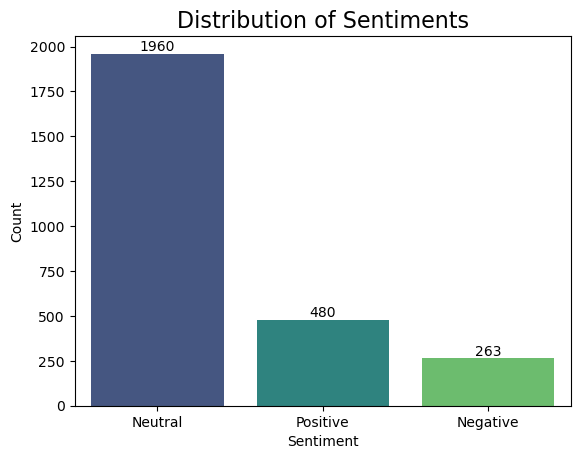

In [79]:
import seaborn as sns

# Create a barplot of the sentiment distribution of comments
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{int(p.get_height())}', 
            ha='center', va='bottom', color='black')  

ax.set_title('Distribution of Sentiments', fontsize=16) 
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')

plt.show()


In [39]:
# Remove unwanted text
def remove_unwanted_texts(text):
    text = re.sub(r'\bamp\b', '', text)     # remove 'amp'
    text = re.sub(r'\brt\b', '', text)      # remove 'rt'
    text = re.sub(r'\b[a-zA-Z]\b', '', text)  # remove single letter
    
    return text

df3['Tweet'] = df3['Tweet'].apply(remove_unwanted_texts)

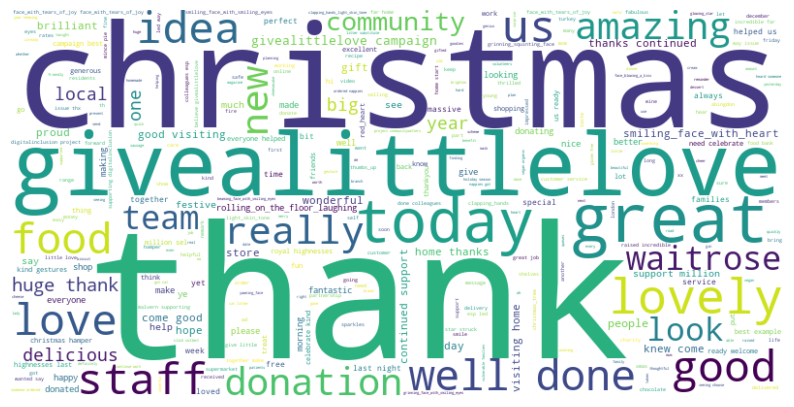

In [44]:
# Generate a word cloud of positive sentiments
plt.figure(figsize=(10, 10))

text = " ".join(df3[df3.Sentiment == 'Positive']['Tweet'])

wc = WordCloud(background_color='white', max_words=1000, width=800, height=400)
wc.generate(text)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  
plt.show()

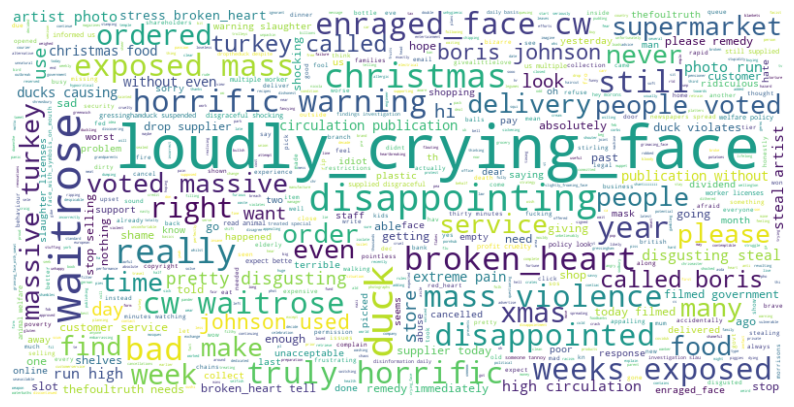

In [47]:
# Generate a word cloud of negative sentiments
plt.figure(figsize=(10, 10))

text = " ".join(df3[df3.Sentiment == 'Negative']['Tweet'])

wc = WordCloud(background_color='white', max_words=1000, width=800, height=400)
wc.generate(text)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  
plt.show()


# Topic Modeling

In [29]:
df2['full_text']

24       come on isn time supermarkets committed exclus...
42       waitrose basically funnel everybody wee tight ...
53       rt when really need kind word gesture we abili...
60                                   rt loudly_crying_face
63       thanks local waitrose closed delivery option l...
                               ...                        
24758    rt waitrose why won t you droptheduck despite ...
24769    loved article kitchen food mag you described w...
24781    rt dear i want tab i shop online states add fo...
24793                        we cauliflower lemons blessed
24801    complex fruity smoky finish says i must say no...
Name: full_text, Length: 2703, dtype: object

In [31]:
#Tokenization
def generate_tokens(tweet):
    words=[]
    for word in tweet.split(' '):
    # using the if condition because we introduced extra spaces during text cleaning
         if word != '' and word not in stop_words:
           words.append(word)
    return words

#storing the generated tokens in a new column named 'tokens'
df2['tokens']=df2.full_text.apply(generate_tokens)

/var/folders/hl/zvxnpgb53j78sh4663wdwq3h0000gn/T/ipykernel_95968/615735795.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['tokens']=df2.full_text.apply(generate_tokens)


In [32]:
df2['tokens'].head()

24    [come, time, supermarkets, committed, exclusiv...
42    [waitrose, basically, funnel, everybody, wee, ...
53    [rt, really, need, kind, word, gesture, abilit...
60                             [rt, loudly_crying_face]
63    [thanks, local, waitrose, closed, delivery, op...
Name: tokens, dtype: object

In [73]:
# Remove unwanted texts
def remove_unwanted_texts(words):
    cleaned_words = []
    for word in words:
        word = re.sub(r'\b[a-zA-Z]\b', '', word) # Remove individual letters
        word = re.sub(r'\b(amp|rt|co|la|de|à|tab|hi|ba)\b', '', word)   #  remove meaningless term
        
        if word:  
            cleaned_words.append(word)
    return cleaned_words

df2['tokens'] = df2['tokens'].apply(remove_unwanted_texts)


/var/folders/hl/zvxnpgb53j78sh4663wdwq3h0000gn/T/ipykernel_95968/40057686.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['tokens'] = df2['tokens'].apply(remove_unwanted_texts)


In [75]:
#Create an dictionary
def create_dictionary(words):
    return corpora.Dictionary(words)
id2word=create_dictionary(df2['tokens'])
print(id2word)

Dictionary<3554 unique tokens: ['come', 'committed', 'compost', 'exclusively', 'offer']...>


In [76]:
#Converting Text Data into Bag-of-Words Models
def create_document_matrix(tokens,id2word):
    corpus = []
    for text in tokens:
        corpus.append(id2word.doc2bow(text))
    return corpus
#passing the dataframe column having tokens and dictionary
corpus=create_document_matrix(df2['tokens'],id2word)
print(df2['tokens'].iloc[0])
print(corpus[0])

['come', 'time', 'supermarkets', 'committed', 'exclusively', 'peatfree', 'compost', 'offer']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]


In [77]:
#Creating an LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            random_state=100,
                                            passes=10
                                             )

In [78]:
#Visualize the LDA models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=10)
vis
     

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.472263  0.071491       1        1  26.201435
5      0.117777  0.429695       2        1  16.844480
9     -0.318884 -0.193826       3        1   9.348612
0     -0.278197  0.182094       4        1   8.968103
7      0.190108 -0.285380       5        1   8.053386
3     -0.088181  0.168528       6        1   7.954385
6     -0.080480 -0.312524       7        1   7.580164
8     -0.189463 -0.026796       8        1   5.451237
1      0.112341  0.067354       9        1   5.040721
4      0.062716 -0.100637      10        1   4.557476, topic_info=                Term        Freq       Total Category  logprob  loglift
53              want  562.000000  562.000000  Default  10.0000  10.0000
37            bought  450.000000  450.000000  Default   9.0000   9.0000
39               gin  442.000000  442.000000  Default   8.0000   8.0000
36            bottle  440.000000  440.000000  Default   7.0000   7.0000
40               ice  436.000000  436.000000  Default   6.0000   6.0000
..               ...         ...         ...      ...      ...      ...
250  givealittlelove   12.688224   51.488884  Topic10  -4.3420   1.6877
121              one   10.261057   30.999064  Topic10  -4.5543   1.9828
22              need   11.402806   71.103920  Topic10  -4.4488   1.2581
31              food   15.594383  336.831266  Topic10  -4.1358   0.0157
96             today   10.806604   81.529368  Topic10  -4.5025   1.0676

[157 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2486     10  0.933225        ad
46        2  0.996002       add
546       3  0.971409    advice
68        5  0.970726       air
1745     10  0.864483  although
...     ...       ...       ...
342       7  0.688532      xmas
411       4  0.065017      year
411       6  0.801878      year
411       8  0.108362      year
507       8  0.906917       yes

[238 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 10, 1, 8, 4, 7, 9, 2, 5])